In [1]:
# Mount Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Specify working directory.
FOLDERNAME = 'cs231n/project/'
%cd /content/drive/My\ Drive/$FOLDERNAME

# Ensure that the Python interpreter of the Colab VM can load python files from
# within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive
/content/drive/My Drive/cs231n/project


## Create videos dataframe
Download 
BII Sneeze-Cough Human Action Video Dataset at https://web.bii.a-star.edu.sg/~chengli/FluRecognition/videos/biisc.zip, unzip it, and save the `videos` folder under directory `cs231n/project/dataset/videos`.

Video File Naming Convention:

\{subject id: 4 char\}_{gender: 1 char}_\{action: 4 char\}_\{stand or walk: 3 char\}_\{pose: 3 char\}[_HF].avi


In [2]:
import os
import pandas as pd

video_path = 'dataset/videos/'
videos = os.listdir(video_path)
subjects = []
actions =[]

for vid in videos:
  # Read index.
  subjects.append(vid[:4])
  # Read actions
  actions.append(vid.split('_')[2])

# Convert actions to 1 = flu sym, 0 = no flu sym.
mapping = {
    'CALL': 0,
    'COUG': 1,
    'DRIN': 0,
    'SCRA': 0,
    'SNEE': 1,
    'STRE': 0,
    'WAVE': 0,
    'WIPE': 0,
}
labels = [mapping[x] for x in actions]    

df_videos = pd.DataFrame({
    'video_subject': subjects,
    'video_name': videos,
    'action': actions,
    'label': labels
    
})
df_videos.head()

,video_subject,video_name,action,label
0,S004,S004_M_SCRA_WLK_RGT.avi,SCRA,0
1,S001,S001_M_WIPE_WLK_RGT.avi,WIPE,0
2,S001,S001_M_WAVE_WLK_LFT_HF.avi,WAVE,0
3,S001,S001_M_SCRA_STD_RGT_HF.avi,SCRA,0
4,S006,S006_M_WAVE_STD_LFT.avi,WAVE,0


## Create Train/Test datasets

From the paper authors: In our current experiments, the videos from subjects S002, S003, S004, S005, S006 are used for testing and the rest are used for training.

In [3]:
df_videos_train = df_videos.loc[~df_videos['video_subject'].isin(
    ['S002','S003', 'S004', 'S005', 'S006'])].reset_index()
df_videos_test  = df_videos.loc[df_videos['video_subject'].isin(
    ['S002','S003', 'S004', 'S005', 'S006'])].reset_index()
print(df_videos_train.groupby('label').count())
print(df_videos_test.groupby('label').count())

       index  video_subject  video_name  action
label                                          
0       1080           1080        1080    1080
1        360            360         360     360
       index  video_subject  video_name  action
label                                          
0        360            360         360     360
1        120            120         120     120


## Create folders for Train & Test frames

In [4]:
frames_path = 'dataset/frames/'
train_frames_path = os.path.join(frames_path, 'train')
test_frames_path = os.path.join(frames_path, 'test')
try:
    os.mkdir(frames_path)
except FileExistsError as ae:
    print('Frames Folder Already Created')
try:
    os.mkdir(train_frames_path)
except FileExistsError as ae:
    print('Train_Videos Folder Already Created')
try:
    os.mkdir(test_frames_path)
except FileExistsError as ae:
    print('Test_Videos Folder Already Created')

Frames Folder Already Created
Train_Videos Folder Already Created
Test_Videos Folder Already Created


### Extract frames from videos

We extract two frames from each second of the video and save the frames as images.

In [5]:
# Read the video files, extract frames from each corresponding video and put
# them in the respective train/test folder.
import cv2

def video_capturing_function(df, folder_name):
    for _, row in df.iterrows():
        _, video_subject, video_name, action, label = row
        video_read_path = os.path.join(video_path, video_name)
        try:
            os.mkdir(os.path.join(os.path.join(frames_path, folder_name),
                                  video_name.split(".")[0]))
        except:
            print("File Already Created")
        
        train_write_file=os.path.join(os.path.join(frames_path, folder_name),
                                  video_name.split(".")[0])
        cap=cv2.VideoCapture(video_read_path)
        cap.set(cv2.CAP_PROP_FPS, 20)
        frame_rate=int(cap.get(5))
        
        count=0
        while(cap.isOpened()):
            frame_id = cap.get(1)
            ret, frame = cap.read()
            if (ret != True):
                break
            # Extract 2 frames from each second.
            if (2 * frame_id % frame_rate == 0):
                filename ="frame%d.jpg" % count; count+=1
                frame_grey=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(os.path.join(train_write_file,filename), frame_grey)
        cap.release()

    return print("All frames written in the: "+folder_name+" Folder")

video_capturing_function(df_videos_train, 'train')
video_capturing_function(df_videos_test, 'test')

All frames written in the: train Folder
All frames written in the: test Folder


In [6]:
# See how many frames are captured for each video.
train_path='/content/drive/My Drive/cs231n/project/dataset/frames/train/'
test_path='/content/drive/My Drive/cs231n/project/dataset/frames/test/'

vid_file_name=df_videos_train.video_name[0].split('.')[0]

train_frames=[]
for i in range(len(df_videos_train.video_name)):
    vid_file_name=df_videos_train.video_name[i].split('.')[0]
    train_frames.append(len(os.listdir(os.path.join(train_path, vid_file_name))))

test_frames=[]
for i in range(len(df_videos_test.video_name)):
    vid_file_name=df_videos_test.video_name[i].split('.')[0]
    test_frames.append(len(os.listdir(os.path.join(test_path,vid_file_name))))

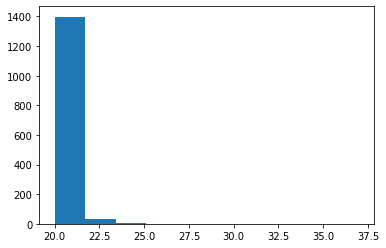

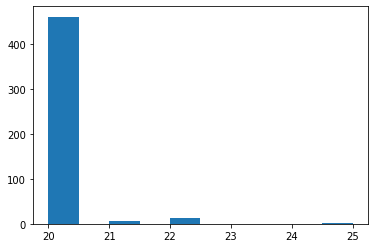

In [7]:
import matplotlib.pyplot as plt

plt.hist(train_frames)
plt.show()

plt.hist(test_frames)
plt.show()


## Making sure that each video has at least 20 frames

Some videos are of length <10 secs, so the frames captured from them are less than 20. We will generate extra frames by creating the copies of the frames at the start and put them at the end. This is to make sure that we have at least 20 frames in each video.

In [10]:
import shutil

def frame_generating_function(dataset, dir_path):
    for i in range(len(dataset.video_name)):
        vid_namu = dataset.video_name[i]
        vid_path = os.path.join(dir_path,vid_namu.split(".")[0])
        len_frame = len(os.listdir(vid_path))
        j = 20 - len(os.listdir(vid_path))
        if j > 0:
            list_frames=os.listdir(vid_path)
            c=0
            for k in range(j):
                list_frames=os.listdir(vid_path)
                frame=os.path.join(vid_path,list_frames[c])
                countu=k+len_frame
                new_frame="frame%d.jpg" % countu
                shutil.copy2(frame,os.path.join(vid_path,new_frame))
                c+=1
        else:
            pass
    return print("Frame Generation Done!")
    
train_path='/content/drive/My Drive/cs231n/project/dataset/frames/train/'
test_path='/content/drive/My Drive/cs231n/project/dataset/frames/test/'

frame_generating_function(df_videos_train, train_path)
frame_generating_function(df_videos_test, test_path)

Frame Generation Done!
Frame Generation Done!
